c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\util\dtype.py:126: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint16.
  .format(dtypeobj_in, dtypeobj_out))
c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from int16 to uint16
  .format(dtypeobj_in, dtypeobj_out))


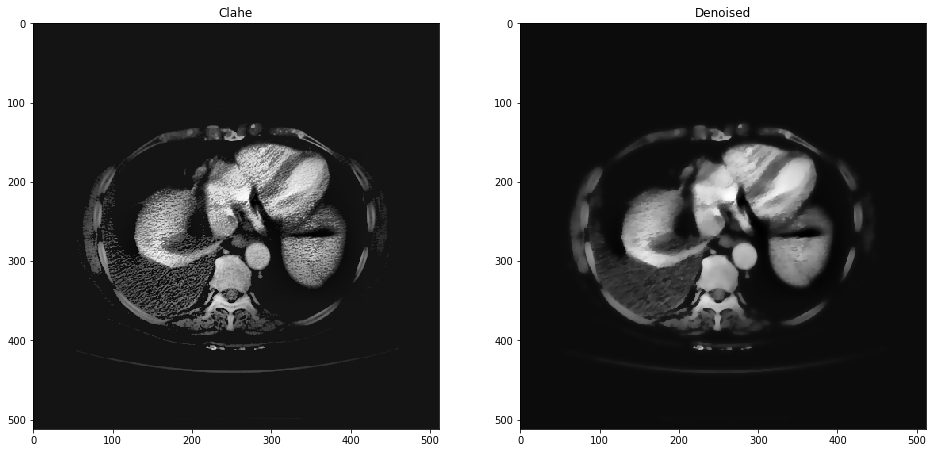

         SSIM =  0.902841194930341        MSE =  0.0010676637723019567        PSNR =  126.04512100927889
None


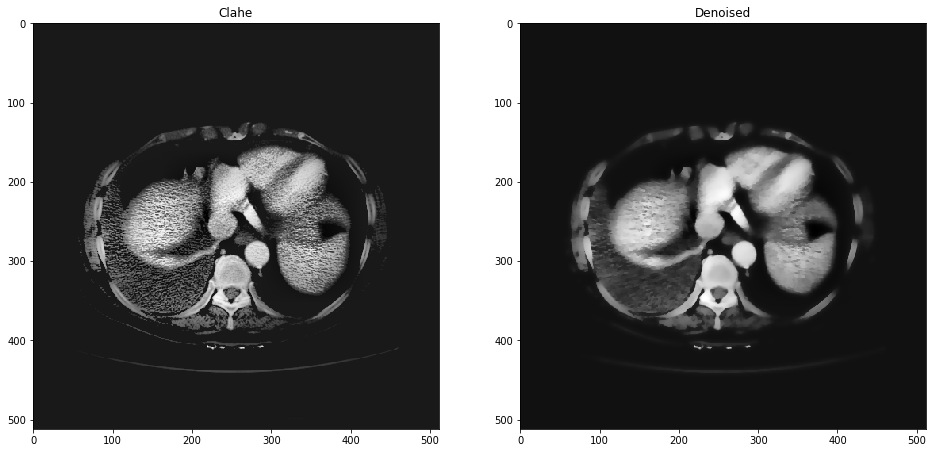

         SSIM =  0.8925116847163964        MSE =  0.0014002174671651603        PSNR =  124.86751116527009
None


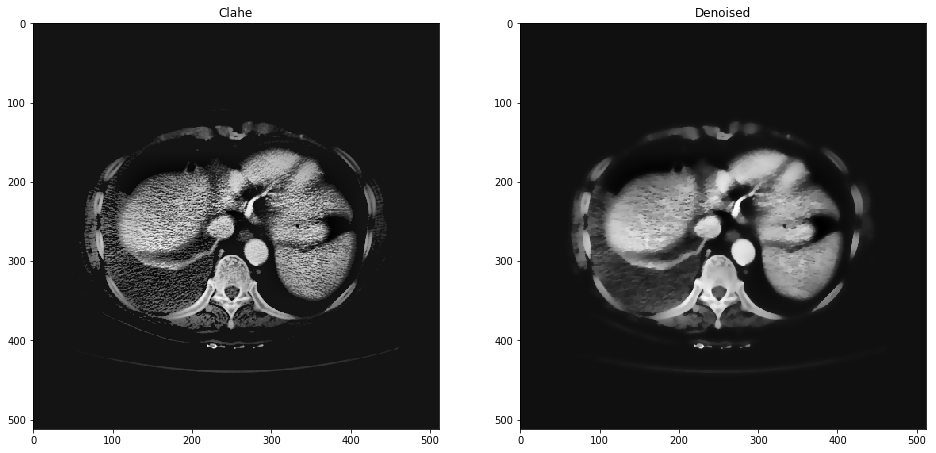

         SSIM =  0.8859134331027905        MSE =  0.0015909192860501691        PSNR =  124.3129846088971
None


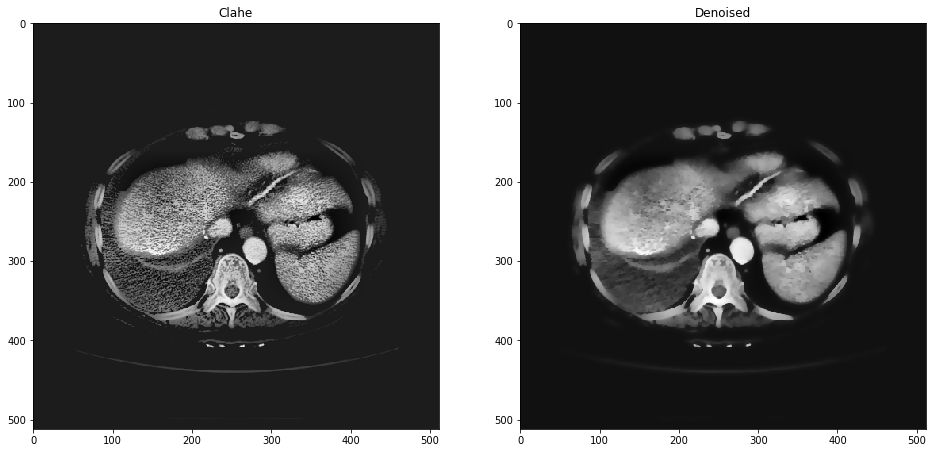

         SSIM =  0.8789040587237706        MSE =  0.0014348623151690355        PSNR =  124.7613637798045
None


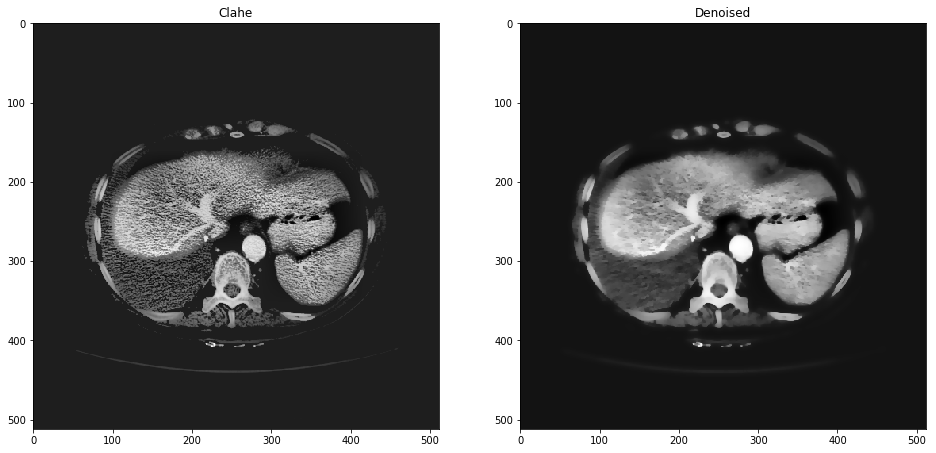

         SSIM =  0.8687393604193134        MSE =  0.00168384252356124        PSNR =  124.06645134586776
None


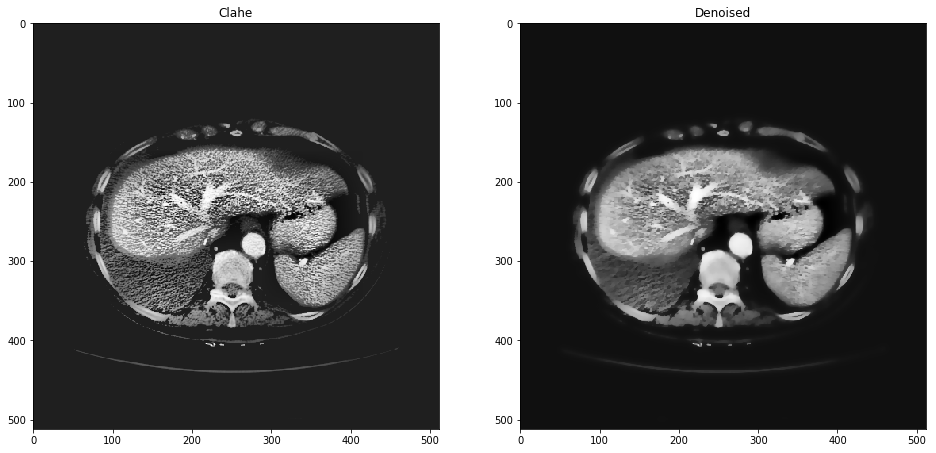

         SSIM =  0.8883366320391486        MSE =  0.0021290902457026953        PSNR =  123.04752537271114
None


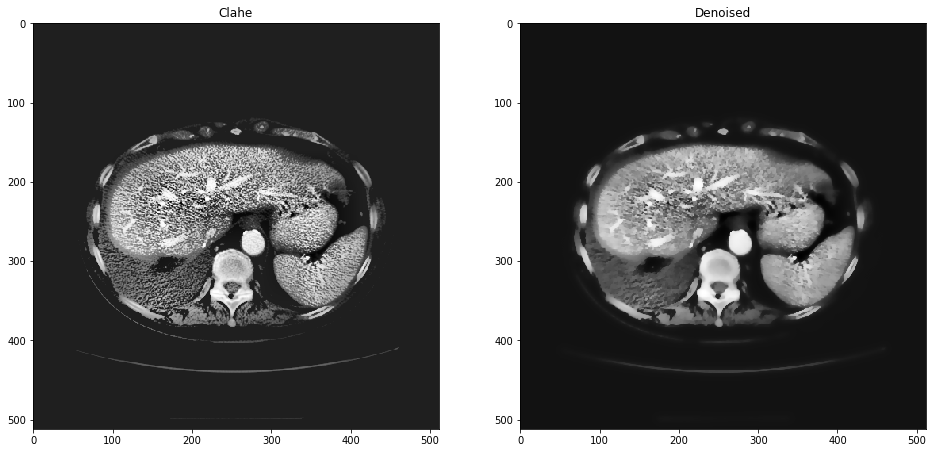

         SSIM =  0.8873784885235234        MSE =  0.0022290336045199363        PSNR =  122.84829991653417
None


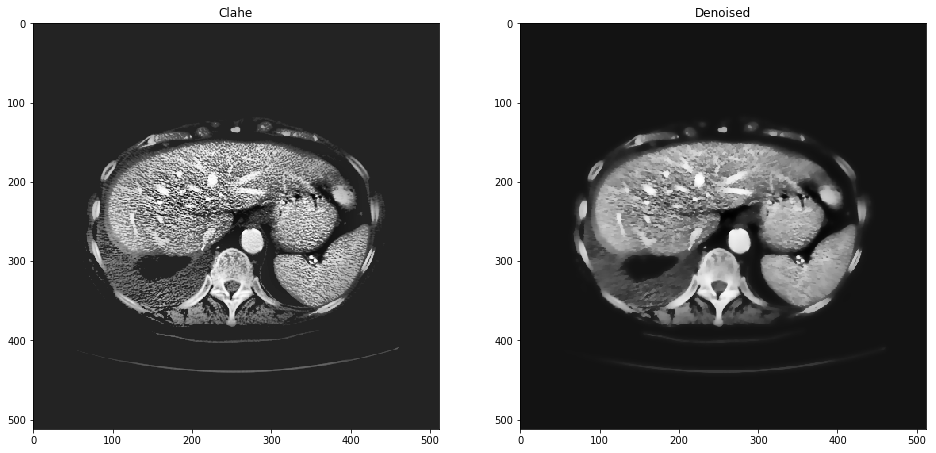

         SSIM =  0.8889912463192962        MSE =  0.0023046768010902825        PSNR =  122.70336577303576
None


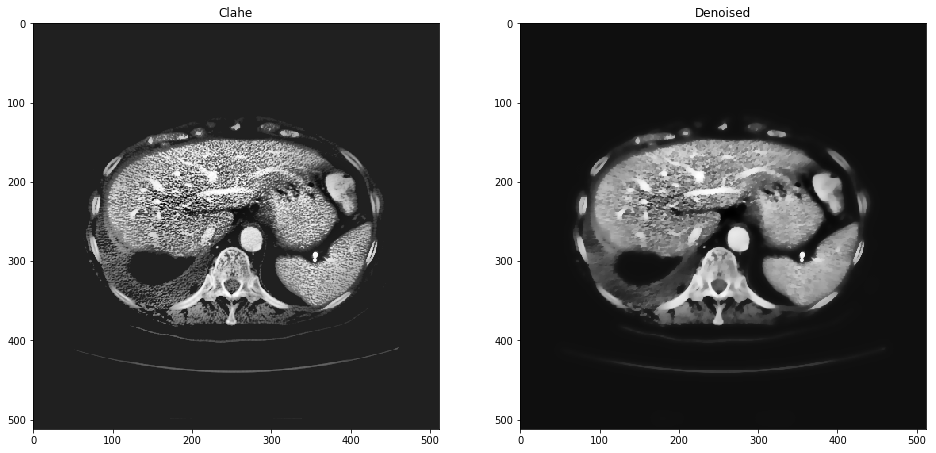

         SSIM =  0.8912427057914256        MSE =  0.002132661574481315        PSNR =  123.04024663471738
None


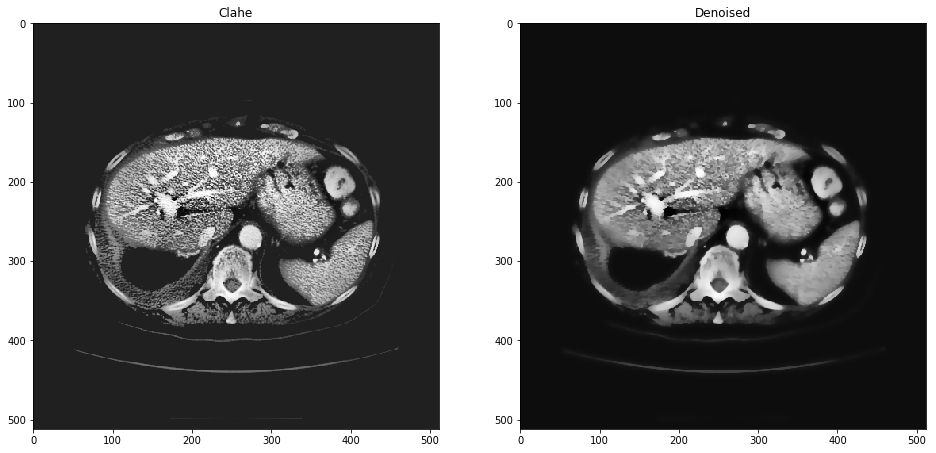

         SSIM =  0.8936399219179034        MSE =  0.001914633639444807        PSNR =  123.50860922483841
None


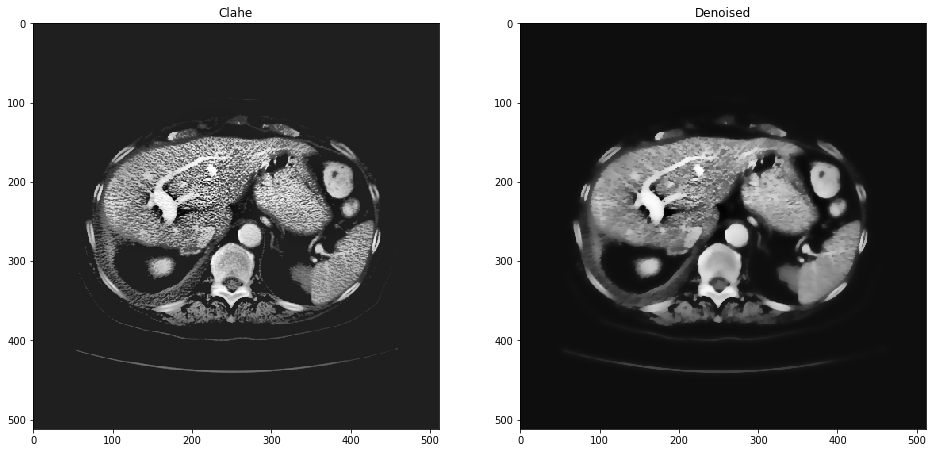

         SSIM =  0.8982748977030317        MSE =  0.0017333711012873024        PSNR =  123.94055055787302
None


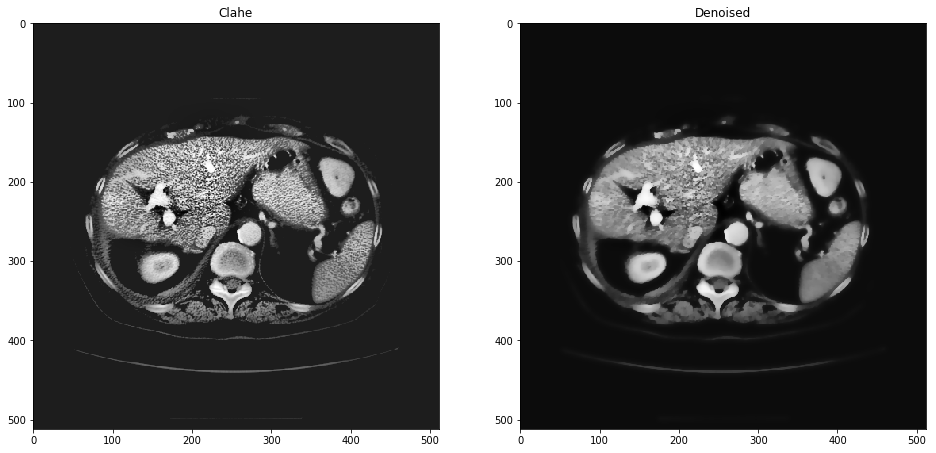

         SSIM =  0.9043994881064581        MSE =  0.001604403689937662        PSNR =  124.27632955394088
None


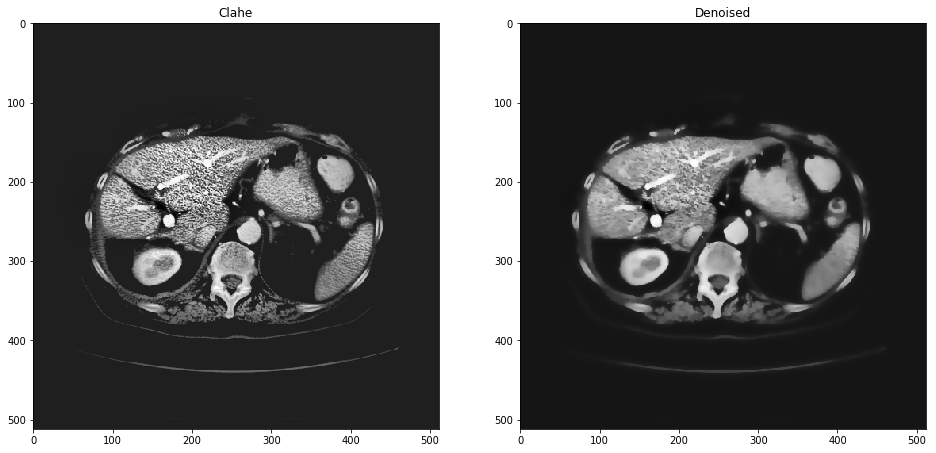

         SSIM =  0.9089864714216553        MSE =  0.0014531696912764018        PSNR =  124.70630276314417
None


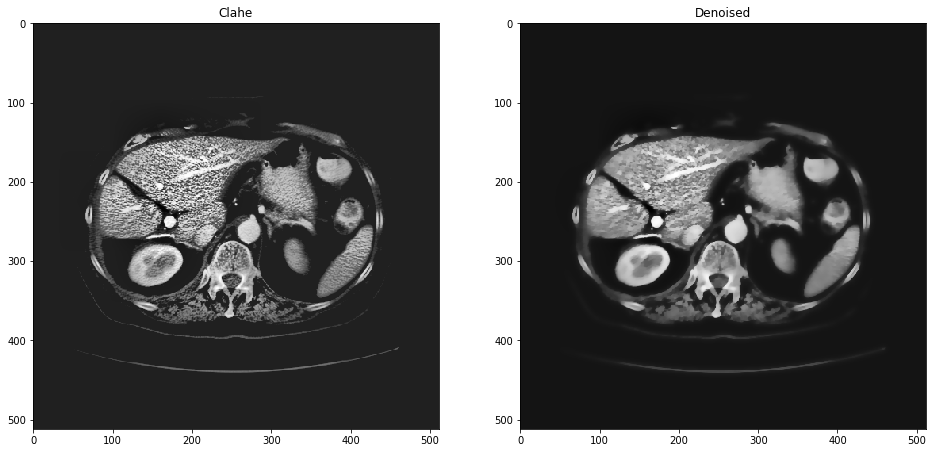

         SSIM =  0.9147864087775394        MSE =  0.0014104803039510186        PSNR =  124.8357958151633
None


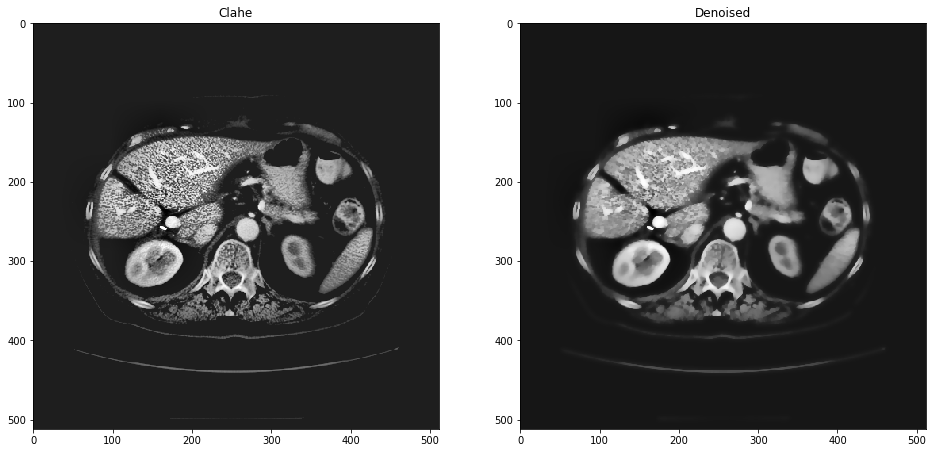

         SSIM =  0.9184608175660534        MSE =  0.0012700246407882276        PSNR =  125.29134460389862
None


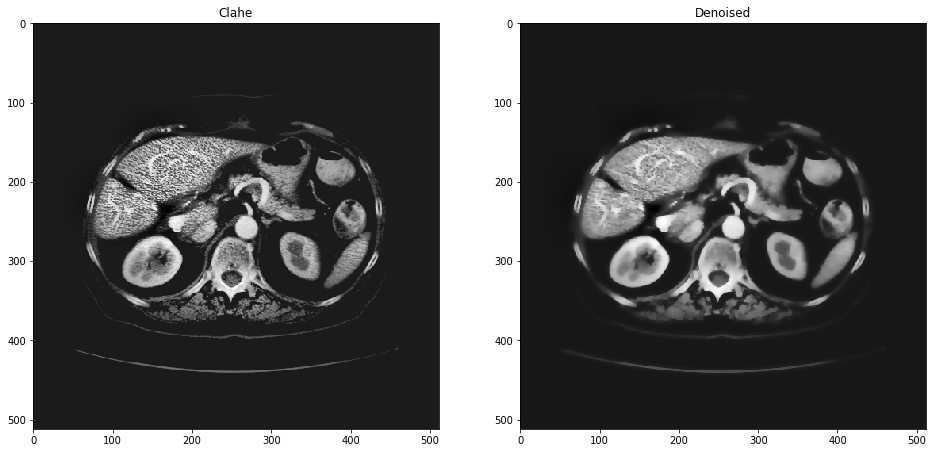

         SSIM =  0.920759678822105        MSE =  0.001188310196787992        PSNR =  125.58016783746814
None


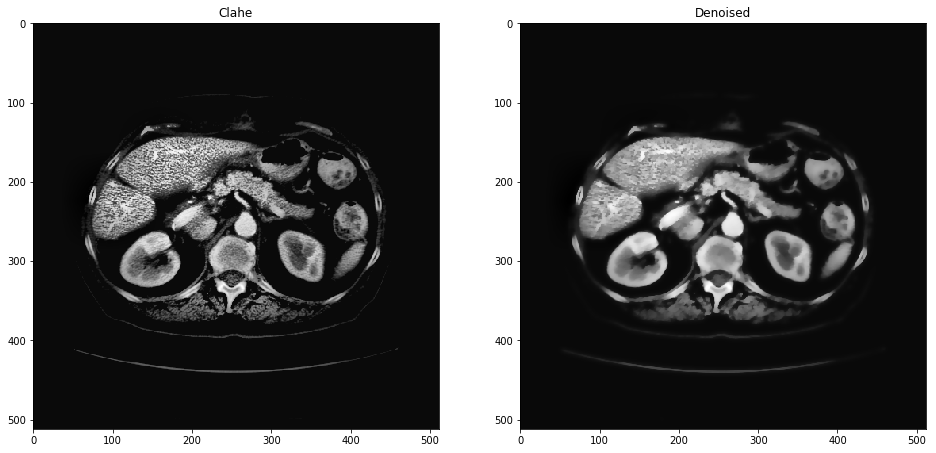

         SSIM =  0.9230035304387586        MSE =  0.0011023013648819786        PSNR =  125.90646262368217
None


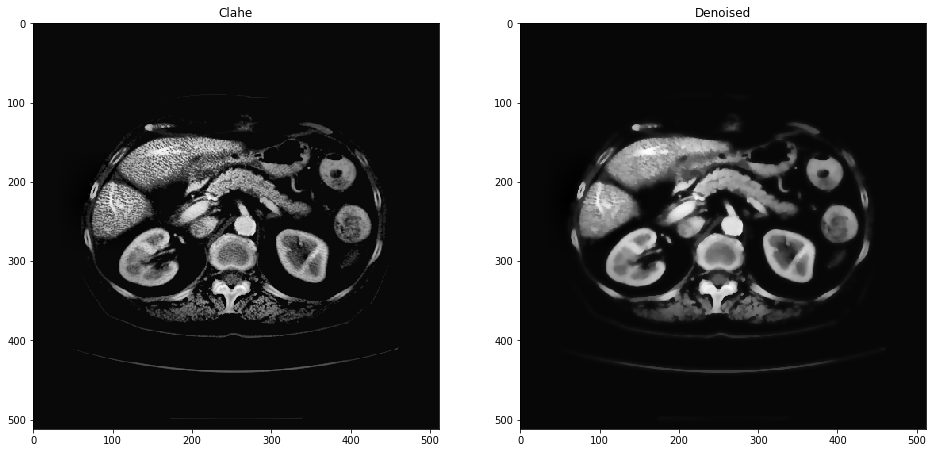

         SSIM =  0.9241327295808476        MSE =  0.0009045773593527628        PSNR =  126.76500893931801
None


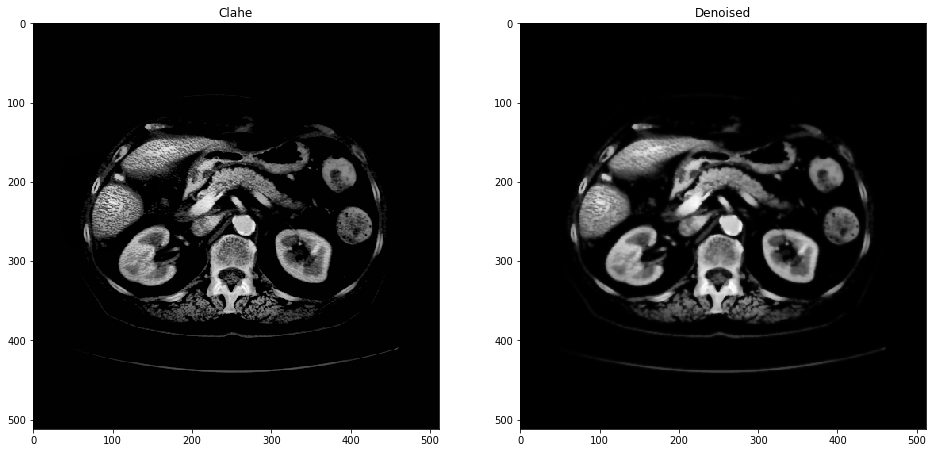

         SSIM =  0.9581079294321205        MSE =  0.00047532546381823286        PSNR =  129.5595552687865
None


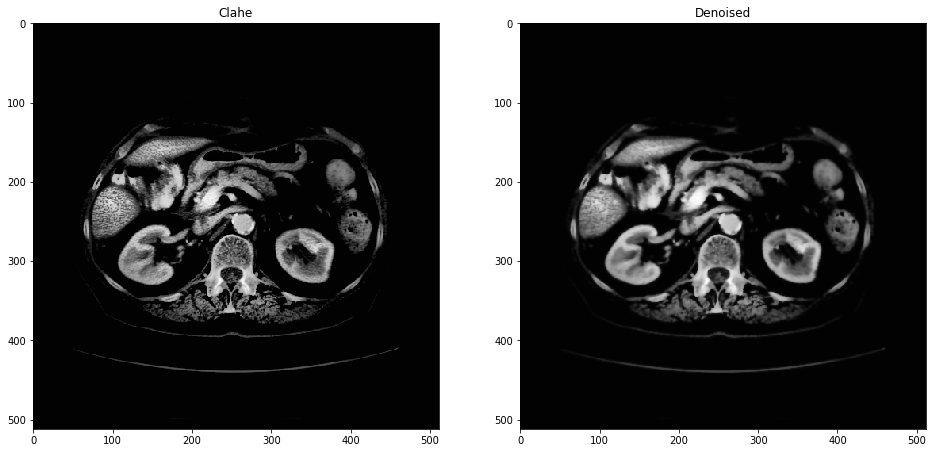

         SSIM =  0.964555080137752        MSE =  0.00043858632522321417        PSNR =  129.90891520938388
None


In [47]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
from skimage.measure import compare_psnr as psnr
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import exposure
import pydicom
import os

%matplotlib inline

# with and without contrast: clahe + denoise_tv_chambolle
SRC_DIR = 'C:/Users/hp/Downloads/tcga-lihc/TCGA-LIHC_CT_DCM/TCGA-DD-A1EJ/06-08-2001-CT ABDPELVIS W AND WO CONTRAST-00650/3-ABDOMEN WITH CONTRAST-66577'

def compare_images(title, original, processed):
    mse_noise = mse(original, processed)
    ssim_noise = ssim(original, processed, data_range=processed.max() - processed.min())
    psnr_noise = psnr(original, processed, 65535)
    print(title, "        SSIM = ", ssim_noise, "       MSE = ", mse_noise, "       PSNR = ", psnr_noise)

def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure(figsize=(8, 20))
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

def read_dcm(inputdir, file):
    ds = pydicom.dcmread(inputdir + '/' + file)
    image = np.stack(ds.pixel_array)
    image = image.astype(np.int16)
    image[image == -2000] = 0
    intercept = ds.RescaleIntercept
    slope = ds.RescaleSlope

    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)

    image += np.int16(intercept)

    #return np.array(image, dtype=np.float64)
    return image

def window_leveling(img):
    p_lo, p_hi = np.percentile(img, (35, 99.7))
    return exposure.rescale_intensity(img, in_range=(p_lo, p_hi))

def clahe(img):
    return exposure.equalize_adapthist(img, clip_limit=0.15)

def dcm_dir_process(inputdir):
    for f in os.listdir(inputdir):
        if not os.path.isdir(inputdir + f):
            img_original = read_dcm(inputdir, f)
            
            # less powerful than adaptative histogram equalization
            #img_histeq = window_leveling(img_original)   
            
            img_clahe = clahe(img_original)
            
            # MSE =  0.002495797221539706        PSNR =  122.35737310632226
            # Very good visual result with and without contrast
            img_denoise = denoise_tv_chambolle(img_clahe, weight=0.1, multichannel=False)
            
            # MSE =  0.00024060458221235618        PSNR =  132.5164271349346
            #img_denoise = denoise_wavelet(img_clahe, multichannel=False)
            
            # MSE =  7.798837198895445e-05        PSNR =  137.40916753012945
            #img_denoise = denoise_bilateral(img_clahe, sigma_color=0.05, sigma_spatial=15, multichannel=False)
            
            show_images(images=[img_clahe, img_denoise], titles=['Clahe', 'Denoised'])
            print(compare_images("", img_clahe, img_denoise))
            
    
dcm_dir_process(SRC_DIR)